In [1]:
cd ..

/Users/austin/code/shiba


In [2]:
from torchvision.datasets import CIFAR10
from torchvision.transforms import ToTensor
from torchvision.models import resnet18

from torch import nn
from torch.optim import SGD, Adam

from shiba import Trainer
from shiba.callbacks import TensorBoard, Metric, Debug, Save, OneCycle
from shiba.metrics import categorical_accuracy
from shiba.vis import classification_snapshot
import matplotlib.pyplot as plt

%matplotlib inline

## Config

In [3]:
!rm -rf runs/ # clear tb logs

In [4]:
data_path = 'cifar'

## Load Data

In [5]:
train_dataset = CIFAR10(data_path, train=True, download=True, transform=ToTensor())
val_dataset = CIFAR10(data_path, train=False, download=True, transform=ToTensor())

Files already downloaded and verified
Files already downloaded and verified


## Simple VGGlike Network

In [6]:
class SimpleNet(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(SimpleNet, self).__init__()
        self.conv1 = nn.Conv2d(in_channels, 6, kernel_size=3, padding=1)
        self.relu = nn.ReLU(inplace=True)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(6, 16, kernel_size=3, padding=1)
        self.fc1 = nn.Linear(16 * 8 * 8, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, out_channels)

    def forward(self, x):
        x = self.relu(self.conv1(x))
        x = self.pool(x)
        x = self.relu(self.conv2(x))
        x = self.pool(x)
        x = x.view(x.size(0), -1)
        x = self.relu(self.fc1(x))
        x = self.relu(self.fc2(x))
        x = self.fc3(x)
        return x


In [7]:
model = SimpleNet(in_channels=3, out_channels=10)
criterion = nn.CrossEntropyLoss()
optimizer = SGD


In [8]:
trainer = Trainer(model, criterion)

## Callbacks

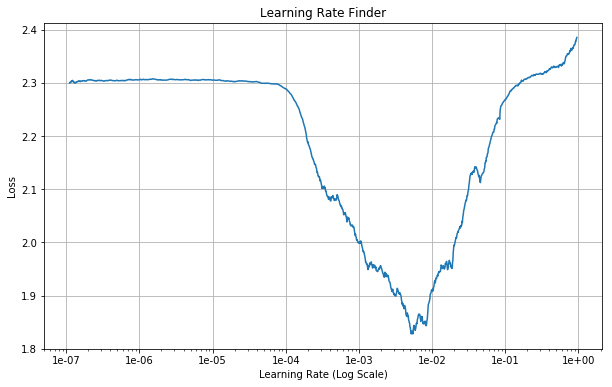

In [9]:
trainer.find_lr(train_dataset)

## Train

In [10]:
callbacks = [TensorBoard(snapshot_func=classification_snapshot),
             Metric(categorical_accuracy, 'accuracy'),
#              Debug(events=['on_batch_end']),
             Save('weights', interval=2),
             OneCycle(max_lr=6e-3)
            ]

In [11]:
trainer.fit(train_dataset, val_dataset, epochs=3, callbacks=callbacks)

In [12]:
trainer.state.core

{'model': SimpleNet(
   (conv1): Conv2d(3, 6, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
   (relu): ReLU(inplace)
   (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
   (conv2): Conv2d(6, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
   (fc1): Linear(in_features=1024, out_features=120, bias=True)
   (fc2): Linear(in_features=120, out_features=84, bias=True)
   (fc3): Linear(in_features=84, out_features=10, bias=True)
 ), 'optimizer': Adam (
 Parameter Group 0
     amsgrad: False
     betas: (0.9, 0.999)
     eps: 1e-08
     lr: 6.000000000000006e-06
     weight_decay: 0
 ), 'criterion': CrossEntropyLoss(), 'device': 'cpu'}

In [13]:
o = Adam(model.parameters())

In [14]:
o.param_groups[0].keys()

dict_keys(['params', 'lr', 'betas', 'eps', 'weight_decay', 'amsgrad'])